# Alex Net

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np

### Preprocess the Dataset

#### 1. Conver the Lables to One-Hot Vectors

In [3]:
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.cifar10.load_data()

# convert the class labels to one hot vectors
#print(y_train.shape)
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train)
y_train = one_hot_encoder.transform(y_train)
y_valid = one_hot_encoder.transform(y_valid)

# put them in a dataset
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

#### 2. Resize input image

In [4]:
def resize(image, label):
    """Resize image to the AlexNet's input size of 227x227
    """
    image = tf.image.resize_with_pad(image, 227, 227, method ='bilinear')
    #label = tf.reshape(label, (-1,))
    return image, label

train_ready = train.map(resize)
train_ready = train_ready.cache().shuffle(buffer_size=100).batch(16)

valid_ready = valid.map(resize)
valid_ready = valid_ready.cache().shuffle(buffer_size=100).batch(16)

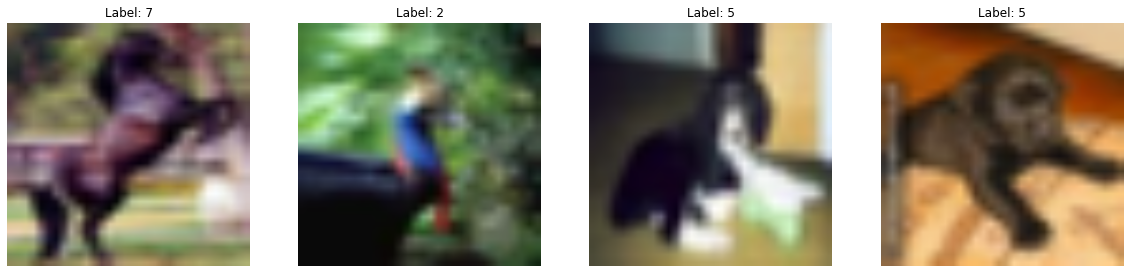

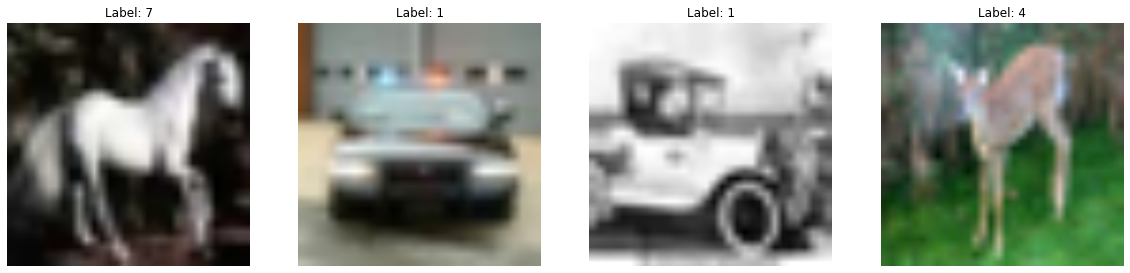

In [5]:
def plot_image(tf_dataset, num_images):
    """Plot the images and its labels
    tf_dataset is contains batches of x, y
    """
    fig, ax = plt.subplots(1, num_images, figsize=(20, num_images*3))
    count = 0

    for image_batch, label_batch in tf_dataset.take(num_images):
    # Since train_ready is now made up of batches, take will return "n" batches now
    # Print 1st image from each batch
        for i in range(image_batch.shape[0]):
            image = image_batch[i]
            label = label_batch[i]
            
            ax[count].imshow(tf.keras.preprocessing.image.array_to_img(image))
            ax[count].set_title("Label: " + str(int(tf.math.argmax(label))))
            ax[count].axis('off')
            count += 1
            break

plot_image(train_ready, 4)
plot_image(valid_ready, 4)

### The AlexNet Architecture

In [6]:
def get_alex_net():
    inputs = tfl.Input(shape=(227,227,3)) 
    
    # 1
    conv = tfl.Conv2D(filters=96,
                    kernel_size=(11,11),
                    strides=(4,4))(inputs)
    print(conv.shape)
    conv = tfl.MaxPool2D(pool_size=(3,3),
                        strides=(2,2))(conv)

    # 2
    conv = tfl.Conv2D(filters=256,
                    kernel_size=(5,5),
                    padding='same')(conv)
    conv = tfl.MaxPool2D(pool_size=(3,3),
                        strides=(2,2))(conv)
    
    # 3 
    conv = tfl.Conv2D(filters=384,
                    kernel_size=(3,3),
                    padding='same')(conv)
    
    # 4
    conv = tfl.Conv2D(filters=384,
                    kernel_size=(3,3),
                    padding='same')(conv)
    
    # 5
    conv = tfl.Conv2D(filters=256,
                    kernel_size=(3,3),
                    padding='same')(conv)
    conv = tfl.MaxPool2D(pool_size=(3,3),
                        strides=(2,2))(conv)

    # 6
    flat = tfl.Flatten()(conv)
    dense = tfl.Dense(units=4096, activation='relu')(flat)
    
    # 7
    dense = tfl.Dense(units=4096, activation='relu')(dense)

    # 8
    output = tfl.Dense(units=10, activation='softmax')(dense)

    return tf.keras.Model(inputs=inputs, outputs=output)

alex_net = get_alex_net()

(None, 55, 55, 96)


In [7]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alex_net.h5", verbose=1, save_best_only=True,)
alex_net.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

alex_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       132748

In [8]:
history = alex_net.fit(train_ready, 
                    validation_data=valid_ready,
                    validation_steps=4,
                    epochs=60,
                    callbacks=[checkpoint_cb])

np.save("history.npy", history.history)

Epoch 1/60
3125/3125 [==============================] - 407s 126ms/step - loss: 2502.8410 - accuracy: 0.0997 - val_loss: 2.3033 - val_accuracy: 0.0625

Epoch 00001: val_loss improved from inf to 2.30330, saving model to alex_net.h5
Epoch 2/60
 186/3125 [>.............................] - ETA: 16:45 - loss: 2.3031 - accuracy: 0.0885

KeyboardInterrupt: 